In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from time import time

from scipy.spatial import distance
from scipy.special import expit

from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score

from sklearn.cluster import KMeans
from sklearn.linear_model import Perceptron
from sklearn.decomposition import PCA


plt.rcParams["figure.figsize"] = [12,8]

In [ ]:
# importing data and analysis
train = pd.read_csv("https://drive.google.com/uc?export=download&id=1sb3dZ-m3ISVVDry9k4_UcaVQVbIOyHJ0")
test = pd.read_csv("https://drive.google.com/uc?export=download&id=1w0vGrGk0g11hUbJ8hzgu999ESBAvo5Ob")

In [ ]:
train.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,tBodyAcc-max()-Y,tBodyAcc-max()-Z,tBodyAcc-min()-X,tBodyAcc-min()-Y,tBodyAcc-min()-Z,tBodyAcc-sma(),tBodyAcc-energy()-X,tBodyAcc-energy()-Y,tBodyAcc-energy()-Z,tBodyAcc-iqr()-X,tBodyAcc-iqr()-Y,tBodyAcc-iqr()-Z,tBodyAcc-entropy()-X,tBodyAcc-entropy()-Y,tBodyAcc-entropy()-Z,"tBodyAcc-arCoeff()-X,1","tBodyAcc-arCoeff()-X,2","tBodyAcc-arCoeff()-X,3","tBodyAcc-arCoeff()-X,4","tBodyAcc-arCoeff()-Y,1","tBodyAcc-arCoeff()-Y,2","tBodyAcc-arCoeff()-Y,3","tBodyAcc-arCoeff()-Y,4","tBodyAcc-arCoeff()-Z,1","tBodyAcc-arCoeff()-Z,2","tBodyAcc-arCoeff()-Z,3","tBodyAcc-arCoeff()-Z,4","tBodyAcc-correlation()-X,Y","tBodyAcc-correlation()-X,Z","tBodyAcc-correlation()-Y,Z",...,fBodyBodyAccJerkMag-entropy(),fBodyBodyAccJerkMag-maxInds,fBodyBodyAccJerkMag-meanFreq(),fBodyBodyAccJerkMag-skewness(),fBodyBodyAccJerkMag-kurtosis(),fBodyBodyGyroMag-mean(),fBodyBodyGyroMag-std(),fBodyBodyGyroMag-mad(),fBodyBodyGyroMag-max(),fBodyBodyGyroMag-min(),fBodyBodyGyroMag-sma(),fBodyBodyGyroMag-energy(),fBodyBodyGyroMag-iqr(),fBodyBodyGyroMag-entropy(),fBodyBodyGyroMag-maxInds,fBodyBodyGyroMag-meanFreq(),fBodyBodyGyroMag-skewness(),fBodyBodyGyroMag-kurtosis(),fBodyBodyGyroJerkMag-mean(),fBodyBodyGyroJerkMag-std(),fBodyBodyGyroJerkMag-mad(),fBodyBodyGyroJerkMag-max(),fBodyBodyGyroJerkMag-min(),fBodyBodyGyroJerkMag-sma(),fBodyBodyGyroJerkMag-energy(),fBodyBodyGyroJerkMag-iqr(),fBodyBodyGyroJerkMag-entropy(),fBodyBodyGyroJerkMag-maxInds,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,-0.567378,-0.744413,0.852947,0.685845,0.814263,-0.965523,-0.999945,-0.999863,-0.994612,-0.994231,-0.987614,-0.943220,-0.407747,-0.679338,-0.602122,0.929294,-0.853011,0.359910,-0.058526,0.256892,-0.224848,0.264106,-0.095246,0.278851,-0.465085,0.491936,-0.190884,0.376314,0.435129,0.660790,...,-1.0,-0.936508,0.346989,-0.516080,-0.802760,-0.980135,-0.961309,-0.973653,-0.952264,-0.989498,-0.980135,-0.999240,-0.992656,-0.701291,-1.000000,-0.128989,0.586156,0.374605,-0.991990,-0.990697,-0.989941,-0.992448,-0.991048,-0.991990,-0.999937,-0.990458,-0.871306,-1.000000,-0.074323,-0.298676,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627,1,STANDING
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,-0.557851,-0.818409,0.849308,0.685845,0.822637,-0.981930,-0.999991,-0.999788,-0.998405,-0.999150,-0.977866,-0.948225,-0.714892,-0.500930,-0.570979,0.611627,-0.329549,0.284213,0.284595,0.115705,-0.090963,0.294310,-0.281211,0.085988,-0.022153,-0.016657,-0.220643,-0.013429,-0.072692,0.579382,...,-1.0,-0.841270,0.532061,-0.624871,-0.900160,-0.988296,-0.983322,-0.982659,-0.986321,-0.991829,-0.988296,-0.999811,-0.993979,-0.720683,-0.948718,-0.271958,-0.336310,-0.720015,-0.995854,-0.996399,-0.995442,-0.996866,-0.994440,-0.995854,-0.999981,-0.994544,-1.000000,-1.000000,0.158075,-0.595051,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317,1,STANDING
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,-0.557851,-0.818409,0.843609,0.682401,0.839344,-0.983478,-0.999969,-0.999660,-0.999470,-0.997130,-0.964810,-0.974675,-0.592235,-0.485821,-0.570979,0.273025,-0.086309,0.337202,-0.164739,0.017150,-0.074507,0.342256,-0.332564,0.239281,-0.136204,0.173863,-0.299493,-0.124698,-0.181105,0.608900,...,-1.0,-0.904762,0.660795,-0.724697,-0.928539,-0.989255,-0.986028,-0.984274,-0.990979,-0.995703,-0.989255,-0.999854,-0.993238,-0.736521,-0

In [ ]:
train.dtypes

tBodyAcc-mean()-X       float64
tBodyAcc-mean()-Y       float64
tBodyAcc-mean()-Z       float64
tBodyAcc-std()-X        float64
tBodyAcc-std()-Y        float64
                         ...   
angle(X,gravityMean)    float64
angle(Y,gravityMean)    float64
angle(Z,gravityMean)    float64
subject                   int64
Activity                 object
Length: 563, dtype: object

In [ ]:
train.shape, train.notna().shape, train.notnull().shape

((7352, 563), (7352, 563), (7352, 563))

These values indicate there is no missing or null values in the dataset.


In [ ]:
train.columns

Index(['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z',
       'tBodyAcc-std()-X', 'tBodyAcc-std()-Y', 'tBodyAcc-std()-Z',
       'tBodyAcc-mad()-X', 'tBodyAcc-mad()-Y', 'tBodyAcc-mad()-Z',
       'tBodyAcc-max()-X',
       ...
       'fBodyBodyGyroJerkMag-kurtosis()', 'angle(tBodyAccMean,gravity)',
       'angle(tBodyAccJerkMean),gravityMean)',
       'angle(tBodyGyroMean,gravityMean)',
       'angle(tBodyGyroJerkMean,gravityMean)', 'angle(X,gravityMean)',
       'angle(Y,gravityMean)', 'angle(Z,gravityMean)', 'subject', 'Activity'],
      dtype='object', length=563)

In [ ]:
train['Activity'].unique()

array(['STANDING', 'SITTING', 'LAYING', 'WALKING', 'WALKING_DOWNSTAIRS',
       'WALKING_UPSTAIRS'], dtype=object)

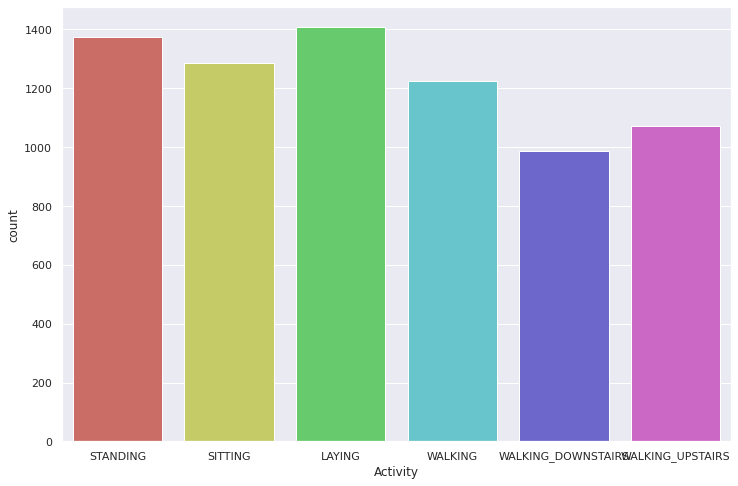

In [ ]:
sns.set()
countplt=sns.countplot(x='Activity', data=train, palette ='hls')
plt.show()

Class ’Laying’ has the most number of samples present in the train set and class ’Walking Down’ has the least number of samples.

In [ ]:
train = train.drop(labels=['subject'], axis=1)
test = test.drop(labels=['subject'], axis=1)

In [ ]:
scaler= StandardScaler()

In [ ]:
train_X = train.drop(labels=['Activity'], axis=1)
train_X = scaler.fit_transform(train_X)
train_y = train['Activity']
train_y_encoded = pd.get_dummies(train_y)

In [ ]:
test_X = test.drop(labels=['Activity'], axis=1)
test_X = scaler.fit_transform(test_X)
test_y = test['Activity']
test_y_encoded = pd.get_dummies(test_y)

In [ ]:
# PCA analysis
pca = PCA(n_components=10)
pca.fit(train_X)

PCA(copy=True, iterated_power='auto', n_components=10, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [ ]:
pca_data = pca.transform(train_X)
pca_data.shape

(7352, 10)

In [ ]:
variation_per_pc = (pca.explained_variance_ratio_)*100
labels = ['PC'+str(x) for x in range(1, len(variation_per_pc)+1)]

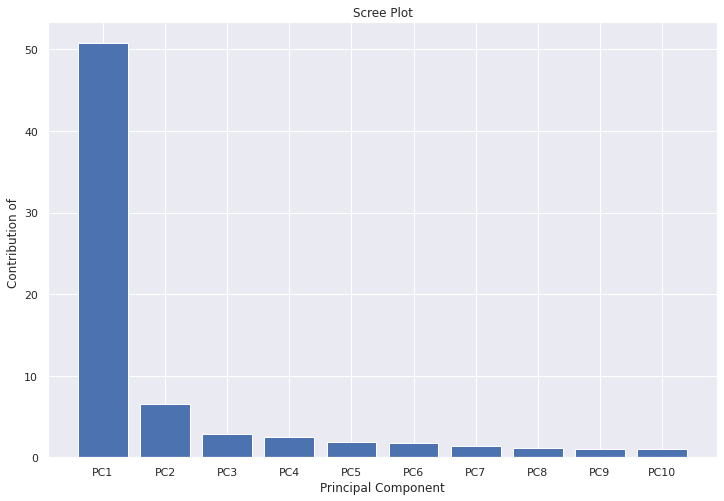

In [ ]:
plt.bar(x=range(1, len(variation_per_pc)+1), height=variation_per_pc, tick_label=labels)
plt.ylabel('Percent Contribution ')
plt.xlabel('Principal Component')
plt.title('Scree Plot')
plt.show()

The plot indicates that principal component 1 captures the most variation, around 51%. This percentage falls sharply for successive principal components.


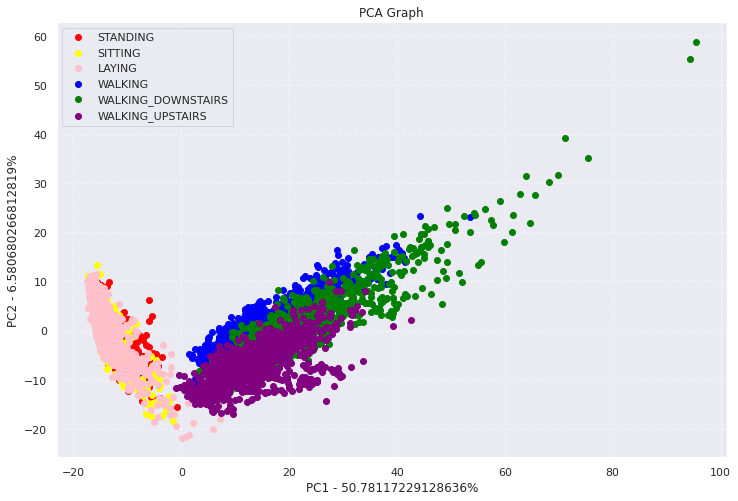

In [ ]:
df = pd.DataFrame(pca_data, columns=labels)
colors = ['red', 'yellow', 'pink', 'blue', 'green', 'purple']
for color, activity in zip(colors, train_y.unique()):
  plt.scatter(x=df.PC1[train_y == activity],
              y=df.PC2[train_y == activity],
              color=color,
              label=activity)

plt.title('PCA Graph')
plt.legend()
plt.grid(alpha=.4,linestyle='--')
plt.xlabel('PC1 - {0}%'.format(variation_per_pc[0]))
plt.ylabel('PC2 - {0}%'.format(variation_per_pc[1]))

plt.show()

The plot describes the projection of dataset on the principal components. From the graph, we can infer that on 2D plane, the projected samples are close to each other. Class 'WALKING DOWNSTAIRS' has some outliers and is more widely spread. Other than that, most of the points are clustered together. PC1 is able to separate 'LAYING', 'STANDING' & 'SITTING' class samples from other class samples. Along PC2, much difference among classes is not there.

In [ ]:
# Implementation for One-vs-All Perceptron model
class CustomPerceptron:
  def __init__(self):
    self.weights = None
    self.bias = None

  def fit(self, data_x, data_y, epochs, learning_rate, ridge_reg_param = 0, lasso_reg_param = 0):
    weights = np.random.uniform(low=-0.3, high=0.3, size=(data_y.shape[1], data_x.shape[1]))
    bias = np.random.uniform(low=-0.3, high=0.3, size=(data_y.shape[1]))
    for _ in range(epochs):
      data_x, data_y = shuffle(data_x, data_y)
      for x, y in zip(data_x, data_y):
        prediction = self.sigmoid(np.dot(weights, x)+bias)
        error = (prediction-y)*prediction*(1-prediction)
        bias -= learning_rate*error 
        error = error.reshape(error.shape[0], 1)
        weights = weights*(1-learning_rate*ridge_reg_param)-learning_rate*error*x
    self.weights = weights
    self.bias = bias

  def test(self, data_x):
    prediction_arr = np.array([self.sigmoid(np.dot(self.weights, x) + self.bias)
                               for x in data_x])
    return [np.argmax(row) for row in prediction_arr]

  def sigmoid(self, x):
    return expit(x)

  def relu(self, x):
    return np.maximum(0,x)

In [ ]:
epochs = [30, 35, 40, 45, 50, 55, 60]
learning_rates = [0.1, 0.01, 0.001, 0.0001, 0.3, 0.03, 0.003, 0.5, 0.05, 0.005, 
                  0.8, 0.08, 0.008]


In [ ]:
best_model = None
best_accuracy = 0
best_n_epoch = 0
best_learning_rate = 0

for epoch in epochs:
  for learning_rate in learning_rates:
    classifier = CustomPerceptron()
    classifier.fit(train_X, train_y_encoded.values, epoch, learning_rate)

    actual_values = [np.argmax(row) for row in test_y_encoded.values]
    predicted_values = classifier.test(test_X)
    accuracy = accuracy_score(actual_values, predicted_values)

    if accuracy > best_accuracy:
      best_accuracy = accuracy
      best_model = classifier
      best_n_epoch = epoch
      best_learning_rate = learning_rate

In [ ]:
actual_values = [np.argmax(row) for row in train_y_encoded.values]
predicted_values = best_model.test(train_X)
train_accuracy = accuracy_score(actual_values, predicted_values)

In [ ]:
print('Best epoch:', best_n_epoch)
print('Best learning rate:', best_learning_rate)
print('Best train accuracy:', train_accuracy)
print('Best test accuracy:', accuracy)

Best epoch: 45
Best learning rate: 0.01
Best train accuracy: 0.9906147986942329
Best test accuracy: 0.9545300305395318


One-vs-all SLP model fits the dataset very well and gives very high test accuracy indicating that the data is linearly separable since SLP draws linear hyperplane for distinguishing the classes.

In [ ]:
epochs = [300, 400, 500, 600, 700, 800, 900, 1000, 1100]
learning_rates = [0.1, 0.01, 0.001, 0.0001, 0.3, 0.03, 0.003, 0.5, 0.05, 0.005, 
                  0.8, 0.08, 0.008]

In [ ]:
best_model = None
best_accuracy = 0
best_epoch = 0
best_lr = 0

for epoch in epochs:
  for learning_rate in learning_rates:
    cls = Perceptron(tol=1e-3, alpha=learning_rate, max_iter=epoch).fit(train_X, train_y)
    score = accuracy_score(test_y, cls.predict(test_X))
    if score > best_accuracy:
      print(epoch, learning_rate, score)
      best_accuracy = score
      best_model = cls
      best_epoch = epoch
      best_lr = learning_rate

300 0.1 0.9480827960637936


The library function gives the above test accuracy for the given values of learning rates and number of epochs



In [ ]:
# Implementation RBF Network model
class RBFNetwork:
  def __init__(self):
    self.repr = None
    self.sigma = None
    self.classifier = None

  def fit(self, train_X, train_y, n_repr, learning_rate, epochs,
          use_random=True, random_seed=None, use_manhattan=False, reg_param=0):
    repr = self.find_repr(train_X, n_repr, use_random, random_seed)
    sigma = self.calc_sigma(repr, use_manhattan)
    phi = self.transform(train_X, repr, sigma, use_manhattan)
    classifier = Perceptron(tol=1e-3, random_state=random_seed,
                            alpha=learning_rate,
                            max_iter=epochs).fit(train_X, train_y)
    self.repr = repr
    self.sigma = sigma
    self.classifier = classifier

  def test(self, test_X, test_y, use_manhattan=False):
    phi = self.transform(test_X, self.repr, self.sigma, use_manhattan)
    return accuracy_score(test_y, self.classifier.predict(test_X))

  def transform(self, data, repr, sigma, use_manhattan):
    n_rows = data.shape[0]
    n_cols = repr.shape[0]
    phi = np.empty((n_rows,n_cols), dtype= float)
    for i in range(n_rows):
        for j in range(n_cols):
            phi[i][j] = self.rbf(data[i], repr[j], sigma, use_manhattan)
    return phi
  
  def find_repr(self, data, n_repr, use_random, random_seed):
    if use_random:
      random_indices = np.random.choice(data.shape[0], size=n_repr, replace=False)
      return data[random_indices, :]
    return KMeans(n_clusters=n_repr, max_iter=300).fit(data).cluster_centers_
  
  def calc_sigma(self, repr, use_manhattan):
    max_dist = 0
    for point_a in repr:
      for point_b in repr:
        if use_manhattan:
          dist = distance.cityblock(point_a, point_b)
        else:
          dist = distance.euclidean(point_a, point_b)
        if dist > max_dist:
          max_dist = dist
    return max_dist/np.sqrt(2*repr.shape[0])

  def rbf(self, point_a, point_b, sigma, use_manhattan):
    if use_manhattan:
      dist = distance.cityblock(point_a, point_b)
      return np.exp(-(dist)/np.power(2*sigma,2))
    else:
      dist = distance.euclidean(point_a, point_b)
      return np.exp(-np.power(dist,2)/np.power(2*sigma,2))

Two different kernel functions have been used here

**A. Traditional Gaussian RBF using Euclidean Function**

This is the commonly used radial basis function in RBF Networks.


<img src="https://i.ibb.co/JHcDmy0/d2-1.png">

Here 'D' is Euclidean Distance metric:

<img src="https://i.ibb.co/f8WgnQk/d2.png">



**B. Custom RBF using Manhattan Function**

<img src="https://i.ibb.co/k5K4YMm/d1-1.png">

Here 'D' is Manhattan Distance metric:

<img src="https://i.ibb.co/gzrKqTT/d1.png">

Here I have introduced a new kernel function. The intuition behind using this function comes from this paper: '[On the surprising behavior of distancemetrics in high dimensional space](https://link.springer.com/chapter/10.1007/3-540-44503-X_27)'. It describes the effect of high dimensionality on the effectiveness of distance metrics and prove that L1 norm i.e. Manhattan distance metric performs consistently better than L2 norm i.e. Euclidean distance metric in terms of measuring distances. Since the given data has high dimensionality, it is intuitive that the new kernel function will work atleast as good as the traditional one. This function can applied in other models as well which make use of distance metrics for finding similarities in case of high dimensionality data.

In [ ]:
# Intitial testing
rbfn = RBFNetwork()
rbfn.fit(train_X, train_y, 600, 1e-6, 300, random_seed=1)
rbfn.test(test_X, test_y)

0.9518154054971157

In [ ]:
n_repr = [561, 600]
n_epochs = [300, 500]
learning_rates = [1e-1, 1e-4, 1e-6,
                  5e-1, 5e-3, 5e-5]

In [ ]:
best_model = None
best_test_accuracy = 0
train_accuracy = 0
best_n_epoch = 0
best_n_repr = 0
best_lr = 0

In [ ]:
# this run is using the Gaussian RBF function
for epoch in n_epochs:
  for learning_rate in learning_rates:
    for repr in n_repr:
      rbfn = RBFNetwork()
      rbfn.fit(train_X, train_y, epochs=epoch,
               learning_rate=learning_rate, n_repr=repr)
      train_score = rbfn.test(train_X, train_y)
      test_score = rbfn.test(test_X, test_y)
      if test_score > best_test_accuracy:
        print('best:', epoch, learning_rate, repr, test_score, train_score)
        best_test_accuracy = test_score
        best_model = rbfn
        best_n_epoch = epoch
        best_n_repr = repr
        best_lr = learning_rate
        train_accuracy = train_score

best: 300 0.1 561 0.9545300305395318 0.9883025027203483
best: 300 0.1 600 0.9609772650152698 0.9900707290533188
best: 500 0.5 600 0.9619952494061758 0.9881664853101197


The best test accuracy 96.19 is corresponding to 500 epochs, 0.5 learning rate and is using 600 centroids

In [ ]:
best_model = None
best_test_accuracy = 0
train_accuracy = 0
best_n_epoch = 0
best_n_repr = 0
best_lr = 0

In [ ]:
n_repr = [561, 600]
n_epochs = [300, 500]
learning_rates = [1e-2, 1e-4, 1e-6, 1e-8,
                  5e-2, 5e-4, 5e-5]

In [ ]:
# this run is using the new RBF function using Manhattan distance
for epoch in n_epochs:
  for learning_rate in learning_rates:
    for repr in n_repr:
      rbfn = RBFNetwork()
      rbfn.fit(train_X, train_y, epochs=epoch,
               learning_rate=learning_rate, n_repr=repr, use_manhattan=True)
      train_score = rbfn.test(train_X, train_y)
      test_score = rbfn.test(test_X, test_y)
      if test_score > best_test_accuracy:
        print('best:', epoch, learning_rate, repr, test_score, train_score)
        best_test_accuracy = test_score
        best_model = rbfn
        best_n_epoch = epoch
        best_n_repr = repr
        best_lr = learning_rate
        train_accuracy = train_score

best: 300 0.01 561 0.9524940617577197 0.9870783460282916
best: 300 0.0001 561 0.9572446555819477 0.9922470076169749
best: 300 1e-08 561 0.9575839837122497 0.9866702937976061
best: 300 0.05 561 0.9592806243637597 0.9876224156692056
best: 500 1e-06 561 0.9667458432304038 0.9885745375408053


The best test accuracy 96.67 is corresponding to 500 epochs, 1e-06 learning rate and is using 561 centroids

**Inference: The new kernel function is working well. However this performance can be enhanced further if we can apply the same distance metric for calculating the centroids in K-Means step. Since the library function does not support custom distance metric and that the custom implementation of K-Means is very slow for the given high dimensional data, I could not implement the version here and it will part of my future work.**